<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Translated by Gleb Filatov (@gleb_filatov). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center> Project "Alice". User Identification Based on Visited Websites
## <center> Week 3. Visual data analysis, and feature engineering
    
This week, we will start doing data exploration via plots as well as some feature engineering. We'll build and explore some features for you so you can build up on this and be able to make features on your own. 

**Week 3 roadmap**
- Part 1. Feature engineering
- Part 2. Visual data exploration
- Part 3. Further feature engineering
- Part 4. Validation of prepared features

In this task we will extensively utilize **seaborn** library (you can install it by using *pip install seaborn* command). Also it will be helpful to take a look at [matplotlib](http://matplotlib.org/users/) and [seaborn](http://seaborn.pydata.org/) docs.

**Your task**
1. Fill in the missing code in the provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/19AKGoSekzO-exZhFWsCHSb3-wR-KT_ATtREKdPWKd24)

## Part 1. Feature engineering

In [2]:
import os
import warnings
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

from tqdm import tqdm_notebook

from matplotlib import pyplot as plt


# disable Anaconda warnings
warnings.filterwarnings('ignore')
# pandas head options
pd.set_option('display.max.columns', 25)

In [3]:
# change the path to data if necessary
PATH_TO_DATA = '../../data/capstone_user_identification'

Create a new function *prepare_train_set_with_fe*, based on *prepare_train_set* and *prepare_sparse_train_set_window*, which will produce following features:

- session_timespan - session duration in seconds (difference between maximal and minimal website visit time in one session)
- #unique_sites - number of unique sites in session
- start_hour - hour, when session started (hour of the minimal timestamp of this session)
- day_of_week - day of week (day of the minimal timestamp of this session)

Function should return a new DataFrame (just like function *prepare_train_set* did) but with **4 more features**. The <font color = 'red'>order</font>, in which features are added is the following - **site1, ..., site10, session_timespan, #unique_sites, start_hour, day_of_week, user_id.**

In [4]:
# utils functions
def pad_seq(seq, width, value):
    return np.pad(seq, pad_width=(0, width), mode="constant", constant_values=value)

def window_with_times(array, session_length=10, window_size=10):
    # input: array with columns: timestamp, site
    start = 0
    end = array.shape[0]
    
    while start < end:
        end_time = array[start:start+session_length, 0].max()
        start_time = array[start:start+session_length, 0].min()
        
        data_slice = array[start:start+session_length, 1]
        # time features         
        session_duration = (end_time - start_time) / np.timedelta64(1, 's')
        session_start_hour = start_time.hour
        session_start_dow = start_time.dayofweek
        unquie_sites = np.unique(data_slice).shape[0]
    
        if len(data_slice) < session_length:
            # if slice len < session len -> pad with zeros up to session len           
            data_slice = pad_seq(data_slice, width=session_length-len(data_slice), value=0)
        
        yield tuple(data_slice) + (session_duration, unquie_sites, session_start_hour, session_start_dow)
        start += window_size 
        
        
def load_obj(path):
    assert path[-3:] == "pkl", "should be pickle"
    with open(path, "rb") as file:
        object_ = pickle.load(file)
    return object_

def save_obj(obj, path):
    assert path[-3:] == "pkl", "should be pickle"
    with open(path, "wb") as file:
        pickle.dump(obj, file)
        print("Saved!")

def to_sparse(df, session_length):
    sites_flatten = df.flatten()
    values = [1] * sites_flatten.shape[0]

    x_sparse = csr_matrix((values,
                        sites_flatten,
                        range(0, sites_flatten.shape[0]  + session_length, session_length)))[:, 1:]
    return x_sparse

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # all paths
    site_freq = load_obj(site_freq_path)
    file_names = sorted(glob(path_to_csv_files + "/*.csv"))
    
    y_user_ids = []
    df_list = []
    
    for file_name in file_names:
        df, user_id = prepare_file(file_name, site_freq, session_length, window_size)
        
        df_list.append(df)
        y_user_ids.extend(user_id)
        
    full_df = pd.DataFrame(np.vstack(df_list), columns=feature_names)
    full_df["target"] = y_user_ids 
    return full_df 

    
def prepare_file(file_path, site_freq, session_length, window_size):
    user_df = pd.read_csv(file_path, sep=",", parse_dates=["timestamp"]).values
    # slow implementation for first attempt(?)
    
    num_windows = np.ceil(user_df.shape[0]/window_size).astype(int)
    df = np.zeros((num_windows, session_length + 4))
    
    site_id_encoder = lambda site_name: site_freq[site_name][0] if site_name != 0 else 0
    
    for row, session in enumerate(window_with_times(user_df, session_length, window_size)):
        site_ids = tuple(site_id_encoder(site) for site in session[:-4]) + session[-4:]
        df[row, :] = site_ids
    
    user_ids = np.array([int(file_path[-8:-4])] * num_windows)
    
    return df, user_ids

Let's test the function on a toy example.

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                                 'day_of_week']
#                 ['time_diff' + str(j) for j in range(1,10)] + \
                
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3.0,2.0,2.0,7.0,2.0,1.0,8.0,5.0,9.0,10.0,7998.0,8.0,9.0,4.0,1
1,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1
2,3.0,2.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2
3,4.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,11.0,4.0,7998.0,5.0,9.0,4.0,3
4,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3


Now apply function *prepare_train_set_with_fe* to 10 users and specify session_length=10

In [8]:
%%time
# # you code here
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 1.76 s, sys: 41.4 ms, total: 1.8 s
Wall time: 1.82 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192.0,574.0,133.0,3.0,133.0,133.0,3.0,133.0,203.0,133.0,33.0,5.0,8.0,4.0,31
1,415.0,193.0,674.0,254.0,133.0,31.0,393.0,3305.0,217.0,55.0,284.0,10.0,8.0,4.0,31
2,55.0,3.0,55.0,55.0,5.0,293.0,415.0,333.0,897.0,55.0,258.0,7.0,8.0,4.0,31
3,473.0,3306.0,473.0,55.0,55.0,55.0,55.0,937.0,199.0,123.0,30.0,6.0,8.0,4.0,31
4,342.0,55.0,5.0,3307.0,258.0,211.0,3308.0,2086.0,675.0,2086.0,6.0,9.0,8.0,4.0,31


Apply function *prepare_train_set_with_fe* to 150 users and specify session_length=10

In [10]:
%%time
# # you code here
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 16.5 s, sys: 340 ms, total: 16.8 s
Wall time: 17.1 s


In [11]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,1.0,4.0,2.0,1.0,4.0,1.0,2.0,1290.0,321.0,57.0,5.0,8.0,4.0,6
1,2.0,23.0,1505.0,1290.0,321.0,321.0,113.0,73.0,49.0,49.0,1618.0,8.0,8.0,4.0,6
2,321.0,205.0,1.0,1.0,1.0,1.0,73.0,321.0,2.0,1.0,2010.0,5.0,8.0,4.0,6
3,1.0,1.0,6998.0,6998.0,5491.0,6998.0,6998.0,1.0,35.0,1.0,2006.0,4.0,9.0,4.0,6
4,1.0,1.0,76.0,1.0,58.0,50.0,58.0,50.0,83.0,76.0,10.0,5.0,9.0,4.0,6


Save features **session_timespan, #unique_sites, start_hour and day_of_week for 10 and 150 users to pickle files.**

In [12]:
# # you code here
new_features_10users = train_data_10users.loc[:, ["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]
new_features_150users = train_data_150users.loc[:, ["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]

In [13]:
save_obj(new_features_10users, PATH_TO_DATA + "/new_features_10users.pkl")
save_obj(new_features_150users, PATH_TO_DATA + "/new_features_150users.pkl")

Saved!
Saved!


In [ ]:
# with open(os.path.join(PATH_TO_DATA, 
#                        'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
#     pickle.dump(new_features_10users, new_features_10users_pkl)
# with open(os.path.join(PATH_TO_DATA, 
#                        'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
#     pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'> Question 1. </font> What's the median session timespan for 10 users data?**

In [20]:
# you code here
new_features_10users.session_timespan.median()

37.0

**<font color='red'> Question 2. </font> What's the median day of week for 10 users data?**

In [21]:
# you code here
new_features_10users.day_of_week.median()

2.0

**<font color='red'> Question 3. </font> What's the median session start hour for 150 users data?**

In [22]:
# you code here
new_features_150users.start_hour.median()

13.0

**<font color='red'> Question 4. </font> What's the median number of unique sites for 150 users data?**

In [23]:
# you code here
new_features_150users['#unique_sites'].median()

7.0

## Part 2. Visual data exploration

Let's assign a name and a color to each user.

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

- Plot a histogram of session length (measured in seconds). Limit x axis to 200 (the right tail is very heavy). Make the histogram of color darkviolet and name the axes.

Text(0.5,0,'session timespan')

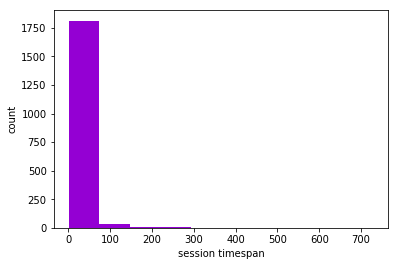

In [42]:
# you code here
plt.hist(train_data_10users['session_timespan'].value_counts(), color="darkviolet");
# plt.ylabel("count")
# plt.xlabel("session timespan")
# plt.xlim(0, 200)

In [43]:
train_data_10users['session_timespan'].value_counts()

2.0         729
3.0         577
1.0         511
4.0         429
5.0         356
6.0         274
9.0         262
8.0         237
7.0         237
10.0        235
11.0        220
14.0        198
12.0        190
13.0        171
45.0        153
16.0        150
15.0        147
19.0        140
60.0        138
23.0        126
18.0        124
17.0        123
30.0        117
21.0        115
20.0        115
22.0        111
61.0        104
28.0        102
26.0        100
32.0         99
           ... 
1603.0        1
174513.0      1
20280.0       1
1782.0        1
774.0         1
737.0         1
2035.0        1
2743.0        1
1683.0        1
6524.0        1
9779.0        1
27427.0       1
83086.0       1
6601.0        1
769.0         1
571.0         1
621.0         1
99473.0       1
1403.0        1
4938.0        1
929.0         1
505.0         1
938.0         1
1389.0        1
2131.0        1
72880.0       1
1103.0        1
1015.0        1
13463.0       1
1525.0        1
Name: session_timespan, 

- Plot a histogram of number of unique sites in session. Make it of color aqua, name the axes.

In [38]:
train_data_10users['session_timespan'].value_counts()

2.0         729
3.0         577
1.0         511
4.0         429
5.0         356
6.0         274
9.0         262
8.0         237
7.0         237
10.0        235
11.0        220
14.0        198
12.0        190
13.0        171
45.0        153
16.0        150
15.0        147
19.0        140
60.0        138
23.0        126
18.0        124
17.0        123
30.0        117
21.0        115
20.0        115
22.0        111
61.0        104
28.0        102
26.0        100
32.0         99
           ... 
1603.0        1
174513.0      1
20280.0       1
1782.0        1
774.0         1
737.0         1
2035.0        1
2743.0        1
1683.0        1
6524.0        1
9779.0        1
27427.0       1
83086.0       1
6601.0        1
769.0         1
571.0         1
621.0         1
99473.0       1
1403.0        1
4938.0        1
929.0         1
505.0         1
938.0         1
1389.0        1
2131.0        1
72880.0       1
1103.0        1
1015.0        1
13463.0       1
1525.0        1
Name: session_timespan, 

In [32]:
# you code here
train_data_10users['#unique_sites'].value_counts()

7.0     2307
6.0     2199
8.0     2045
5.0     1735
9.0     1394
2.0     1249
4.0     1163
3.0      890
10.0     651
1.0      428
Name: #unique_sites, dtype: int64

- Plot a histogram of number of unique sites for **each user separately**. Use *subplots* to fit all the 10 little pictures on a big one. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a color from *color_dic*. Sign the axes in each of the histograms.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    pass
    # you code here

- Plot a histogram of session start hour. Make histogram of color darkgreen, sign the axes.

In [ ]:
# you code here
train_data_10users['start_hour'] 

- Plot histograms of start hour distribution for each of 10 users separately. Use *subplots* to fit all the 10 little pictures on a big one. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a color from color_dic. Sign the axes in each of the histograms.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    pass
    # you code here

- Plot histogram of day of week distribution. Make it of color sienna, sign the axes. 

In [ ]:
# you code here
train_data_10users['day_of_week']

- Plot histograms of day of week distribution for each of 10 users separately. Use *subplots* to fit all the 10 little pictures on a big one. Change x axis labels to `['Mon','Tue','Wed','Thu','Fri','Sat','Sun']` using **set_xticklabels** method. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a **color** from **color_dic**. Sign the axes in each of the histograms.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    pass
    # you code here

- Make conclusions about each user using the plots you just plotted. 

Load the pickle file frequency dict for 10 users you saved earlier.

In [ ]:
# # you code here
# with open 

- Find top-10 most visited sites (top10_sites) and corresponding number of visits (top10_freqs).

In [ ]:
# # you code here
# top10_freqs = 
# top10_sites = 

- Plot seaborn barplot that shows frequencies of top-10 sites visits. Make x-axis names (xticks) vertically oriented, otherwise they do not look good. 

In [ ]:
# # you code here
# sns.barplot 

## Part 3. Further feature engineering

This task will test your creativity. You have to come up with ideas, how else you can use website visit time and other features.

On the next week we will use a "bag of sites" to classify sessions based on which user they belong to. Additionaly, you will use features you create here and we'll see, whether model improves. It is wise to calculate them now and save, like we did in this assignment. 

You may go wild here and explore any feature you want - you have no constraints. 

- year, month and day of session start
- hour of sessions start (with respect to year, month and day)
- time of day
- average time spent on website (for top-30, for example)
- indicator function for popular site visit (again, top-30)
- facebook visit frequency
- .......

Implement the function to create new features and apply to initial data - catalogues with 10 and 150 users. Do it only for dataset, which was created with paramaters session_length=10 and window_size=10. Serialize resulting matrices via pickle. Function may return both only new features and old ones concatenated with new. You are free to choose function signature - no constraints here.

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    pass
    # you code here

In [ ]:
# # you code here
# new_features_10users = feature_engineering

In [ ]:
# # you code here
# new_features_150users = feature_engineering

10. Plot pictures for new features, explore them and comment on the results.

In [7]:
# you code here

Finally, save only those features to pickle files which, on your opinion, would help to identify user more precisely. This applies both to features, that we created in the beginning (session_timespan, #unique_sites, start_hour, day_of_week) and your own. You are free to create all these features not only for sessions of length 10, but for any other combination of *session_length* and *window_size*

In [ ]:
# # you code here
# selected_features_10users = 
# selected_features_150users = 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

Next week, we'll finally start training classification models.